In [ ]:
import pyvista as pv
import numpy as np
from scipy.sparse import csr_matrix

In [17]:
def make_spheres_radiuses_set(nsub=4):
    sphere = pv.Icosphere(radius=1, nsub=nsub)  # More uniform

    points = sphere.points.astype(np.float64)
    faces = sphere.faces.reshape(-1, 4)[:, 1:]

    n_points = len(points)
    edge_set = set()
    rows, cols, dists = [], [], []
    edge_lengths = []

    for tri in faces:
        for i in range(3):
            a, b = tri[i], tri[(i + 1) % 3]
            edge = tuple(sorted((a, b)))
            if edge not in edge_set:
                edge_set.add(edge)
                dist = np.linalg.norm(points[a] - points[b])
                edge_lengths.append(dist)  
                rows.extend([a, b])
                cols.extend([b, a])
                dists.extend([dist, dist])

    graph = csr_matrix((dists, (rows, cols)), shape=(n_points, n_points))
    h = np.mean(edge_lengths)
    
    radiuses = ((np.arange(1, 16) / 10) / h)
    nsub_radises = [(r, nsub) for r in radiuses] 

    return nsub_radises

make_spheres_radiuses_set(2)

[(0.33518611916632424, 2),
 (0.6703722383326485, 2),
 (1.0055583574989726, 2),
 (1.340744476665297, 2),
 (1.675930595831621, 2),
 (2.011116714997945, 2),
 (2.3463028341642693, 2),
 (2.681488953330594, 2),
 (3.016675072496918, 2),
 (3.351861191663242, 2),
 (3.6870473108295667, 2),
 (4.02223342999589, 2),
 (4.357419549162215, 2),
 (4.692605668328539, 2),
 (5.027791787494864, 2)]

In [9]:
for i in range(1, 6):
    graph, faces, points, sphere, h = make_sphere(radius=1,nsub=i)
    print(f"Sphere with nsub={i}:")
    print(f"Number of points: {len(points)}")
    print(f"Number of faces: {len(faces)}")
    print(f"Average edge length: {h:.2f}")
    print()

Sphere with nsub=1:
Number of points: 42
Number of faces: 80
Average edge length: 0.58

Sphere with nsub=2:
Number of points: 162
Number of faces: 320
Average edge length: 0.30

Sphere with nsub=3:
Number of points: 642
Number of faces: 1280
Average edge length: 0.15

Sphere with nsub=4:
Number of points: 2562
Number of faces: 5120
Average edge length: 0.08

Sphere with nsub=5:
Number of points: 10242
Number of faces: 20480
Average edge length: 0.04



Resolution: 4
h: 0.751567526575924
Resolution: 3
h: 1.5008418217932147
Resolution: 2
h: 2.9834171892225214
Resolution: 1
h: 5.822835294260386
h values: [0.751567526575924, 1.5008418217932147, 2.9834171892225214, 5.822835294260386]
Average slope: -0.045
Average slope: nan


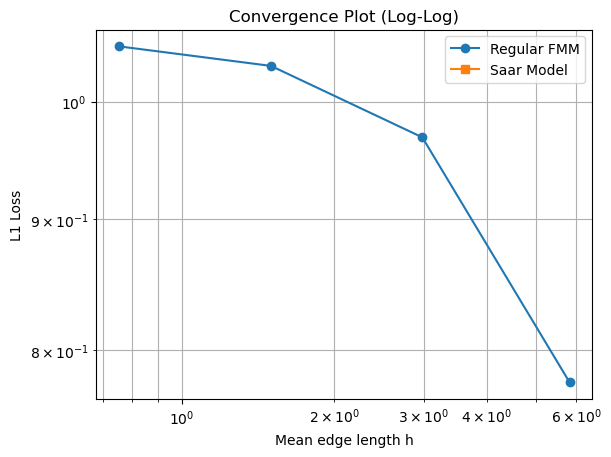

l1_errors_regular_FMM: [1.0511016624490377, 1.0327804871779673, 0.9686331641074003, 0.7774066424106824]
l1_errors_saar_model: [nan, nan, nan, nan]


In [15]:
import torch
import heapq
import pyvista as pv
import numpy as np
from collections import deque
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.sparse import csr_matrix
from models.sphere_models import SpherePointNetRing

global_local_solver = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def make_sphere(radius=1.0, nsub=3):
    # sphere = pv.Sphere(radius=radius, theta_resolution=theta_resolution//2, phi_resolution=phi_resolution)
    sphere = pv.Icosphere(radius=radius, nsub=nsub)  # More uniform

    points = sphere.points.astype(np.float64)
    faces = sphere.faces.reshape(-1, 4)[:, 1:]

    n_points = len(points)
    edge_set = set()
    rows, cols, dists = [], [], []
    edge_lengths = []

    for tri in faces:
        for i in range(3):
            a, b = tri[i], tri[(i + 1) % 3]
            edge = tuple(sorted((a, b)))
            if edge not in edge_set:
                edge_set.add(edge)
                dist = np.linalg.norm(points[a] - points[b])
                edge_lengths.append(dist)  
                rows.extend([a, b])
                cols.extend([b, a])
                dists.extend([dist, dist])

    graph = csr_matrix((dists, (rows, cols)), shape=(n_points, n_points))
    h = np.mean(edge_lengths)
    
    # for i in range(10):  # Check the first 10 points
    #     neighbors = graph[i].nonzero()[1]
    #     print(f"Point {i}: {len(neighbors)} neighbors -> {neighbors}")

    return graph, faces, points, sphere, h


def plot_errors(h_values, errors_regular_FMM, errors_saar_model):
    plt.figure()
    plt.loglog(h_values, errors_regular_FMM, marker='o', label='Regular FMM')
    plt.loglog(h_values, errors_saar_model, marker='s', label='Saar Model')
    plt.xlabel('Mean edge length h')
    plt.ylabel('L1 Loss')
    plt.title('Convergence Plot (Log-Log)')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()


# Plotting
#sphere["GeodesicDistance"] = distances
#sphere.plot(scalars="GeodesicDistance", cmap="viridis", show_edges=False)

#----------------------------Plot for the model----------------------------


def get_3_ring_visited_neighbors(p, graph, status, u, points):
    visited = []
    queue = deque([(p, 0)])  # (node, depth)
    seen = set([p])
    
    while queue:
        current, depth = queue.popleft()
        if depth > 3:
            continue
        if status[current] == 'Visited' and current != p:
            point_xyz = tuple(points[current])  # (x, y, z)
            visited.append([point_xyz[0], point_xyz[1], point_xyz[2], u[current]])
        for neighbor in graph[current].nonzero()[1]:
            if neighbor not in seen:
                seen.add(neighbor)
                queue.append((neighbor, depth + 1))

    return torch.tensor(visited, dtype=torch.float64).T  # Shape: [4, N]




def local_solver_regular_FMM(p, graph, status, u, points):
    min_val = np.inf
    for neighbor in graph[p].nonzero()[1]:
        if status[neighbor] == 'Visited':
            edge_weight = graph[p, neighbor]
            candidate = u[neighbor] + edge_weight
            if candidate < min_val:
                min_val = candidate
    return min_val




def local_solver_model_ring3(p, graph, status, u, points): #fast
    visited_neighbors = get_3_ring_visited_neighbors(p, graph, status, u, points).to(device)  # shape: (4, N) with N ≤ 90
    num_valid = visited_neighbors.shape[1]
    visited_neighbors_padded = F.pad(visited_neighbors, (0, 90 - num_valid), "constant", 0).unsqueeze(0)  # (1, 4, 90)
    mask = torch.zeros(90, dtype=torch.float64)
    mask[:num_valid] = 1
    mask = mask.unsqueeze(0)  # (1, 90)
    point_xyz = torch.tensor(points[p], dtype=torch.float64).unsqueeze(0)  # (1, 3)
    
    # Move to GPU if available
    visited_neighbors_padded = visited_neighbors_padded.to(device)
    point_xyz = point_xyz.to(device)
    mask = mask.to(device)
    
    distance_estimation = global_local_solver(visited_neighbors_padded, point_xyz, mask).item()
    return distance_estimation


def FMM_with_local_solver(graph: csr_matrix, points, source_points, local_solver):
    n_points = graph.shape[0]
    u = np.full(n_points, np.inf)
    status = np.full(n_points, 'Unvisited', dtype=object)
    heap = []  # (u value, point index)

    for p in source_points:
        u[p] = 0
        status[p] = 'Visited'
        for neighbor in graph[p].nonzero()[1]:
            if status[neighbor] == 'Unvisited':
                status[neighbor] = 'Wavefront'
                heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))

    while heap:
        _, p = heapq.heappop(heap)
        if status[p] == 'Visited':
            continue 

        u[p] = local_solver(p, graph, status, u, points)
        status[p] = 'Visited'

        for neighbor in graph[p].nonzero()[1]:
            if status[neighbor] == 'Unvisited' or status[neighbor] == 'Wavefront': #Omer added
                status[neighbor] = 'Wavefront'
                heapq.heappush(heap, (u[p] + graph[p, neighbor], neighbor))
    return u


# def FMM_with_local_solver(graph: csr_matrix, points, source_points, local_solver): #real
#     n_points = graph.shape[0]
#     u = np.full(n_points, np.inf)
#     status = np.full(n_points, 'Unvisited', dtype=object)
#     wavefront_heap = []  # Min-heap of (distance, node)
#     wavefront_set = set()  # To avoid duplicates in heap

#     for p in source_points:
#         u[p] = 0
#         status[p] = 'Visited'
#         for neighbor in graph[p].indices:
#             if status[neighbor] == 'Unvisited':
#                 status[neighbor] = 'Wavefront'
#                 heapq.heappush(wavefront_heap, (np.inf, neighbor))
#                 wavefront_set.add(neighbor)

#     while wavefront_heap:
#         updated_heap = []
#         for i in range(len(wavefront_heap)):
#             _, node = heapq.heappop(wavefront_heap)
#             dist = local_solver(node, graph, status, u, points)
#             heapq.heappush(updated_heap, (dist, node))

#         wavefront_heap = updated_heap
#         heapq.heapify(wavefront_heap)
#         if not wavefront_heap:
#             break

#         minimal_distance, minimal_node = heapq.heappop(wavefront_heap)
#         u[minimal_node] = minimal_distance
#         status[minimal_node] = 'Visited'
#         wavefront_set.discard(minimal_node)

#         for neighbor in graph[minimal_node].indices:
#             if status[neighbor] == 'Unvisited':
#                 status[neighbor] = 'Wavefront'
#                 if neighbor not in wavefront_set:
#                     heapq.heappush(wavefront_heap, (np.inf, neighbor))
#                     wavefront_set.add(neighbor)

#     return u



def true_distances(points, radius, source_idx):
    source = points[source_idx]
    norm_points = points / np.linalg.norm(points, axis=1, keepdims=True)
    norm_source = source / np.linalg.norm(source)
    cosines = norm_points @ norm_source
    cosines = np.clip(cosines, -1.0, 1.0)
    true_distances = radius * np.arccos(cosines)
    return true_distances


resolutions = [4,3,2,1]  # nsub values
radius = 10
h_vals = []
l1_errors_regular_FMM = []
l1_errors_saar_model = []
for nsub in resolutions:
    print(f"Resolution: {nsub}")
    #points = coordinates of each point
    #graph = (number of node a, number of node b, edge length between a and b)
    graph, faces, points, sphere, h = make_sphere(radius=radius, nsub=nsub) #radius=10, nsub=r
    source_idxs = [3, 10, 15, 20] 
    print(f"h: {h}")

    #Load the local solver (the model)
    local_solver = SpherePointNetRing()
    checkpoint = torch.load("checkpoints/ico_radius_1-10.pt", map_location=device)
    local_solver.load_state_dict(checkpoint["model_state_dict"])
    local_solver = local_solver.to(device)
    local_solver.eval()
    global_local_solver = local_solver #make it global

    l1_losses_regular_FMM = []
    l1_losses_saar_model = []
    for source_idx in source_idxs:
        # print(f"Source index: {source_idx}")
        distances_regular_FMM = FMM_with_local_solver(graph, points, [source_idx], local_solver_regular_FMM)
        # distances_saar_model = FMM_with_local_solver(graph, points, [source_idx], local_solver_model_ring3)
        true_geodesic = true_distances(points, radius, source_idx)
        l1_losses_regular_FMM.append(np.mean(np.abs(distances_regular_FMM - true_geodesic)))
        # l1_losses_saar_model.append(np.mean(np.abs(distances_saar_model - true_geodesic)))
        #sphere["GeodesicDistance"] = distances_regular_FMM
        #sphere.plot(scalars="GeodesicDistance", cmap="viridis", show_edges=False)
        #sphere["GeodesicDistance"] = distances_saar_model
        #sphere.plot(scalars="GeodesicDistance", cmap="viridis", show_edges=False)

    l1_loss_regular_FMM = np.mean(l1_losses_regular_FMM)
    l1_loss_saar_model = np.mean(l1_losses_saar_model)
    l1_errors_regular_FMM.append(l1_loss_regular_FMM)
    l1_errors_saar_model.append(l1_loss_saar_model)
    h_vals.append(h)


average_slope_regular_FMM = np.mean(np.diff(l1_errors_regular_FMM) / np.diff(h_vals))
average_slope_saar_model = np.mean(np.diff(l1_errors_saar_model) / np.diff(h_vals))
print(f"h values: {h_vals}")
print(f"Average slope: {average_slope_regular_FMM:.3f}")
print(f"Average slope: {average_slope_saar_model:.3f}")
plot_errors(h_vals, l1_errors_regular_FMM, l1_errors_saar_model)
print(f"l1_errors_regular_FMM: {l1_errors_regular_FMM}")
print(f"l1_errors_saar_model: {l1_errors_saar_model}")
